In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv2
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Bidirectional, LSTM, Dense, Dropout, Flatten, Embedding,Reshape
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
img_dir = '/kaggle/input/persianocrdataset/Shotor_Images'
df=pd.read_csv('/kaggle/input/persianocrdataset/Shotor_Words.csv')
label=df['word']

In [3]:
target_size=(100,50)
images=[]
for i in range(len(df)):
    img_dir = '/kaggle/input/persianocrdataset/Shotor_Images/Shotor_Images/' + df.loc[i, 'image']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(image, target_size)
    images.append(img_resized)

In [5]:
unique_characters = set(''.join(label))

char_to_number = {char: i for i, char in enumerate(unique_characters)}

numerical_labels = [[char_to_number[char] for char in word] for word in label]
padded_sequences = pad_sequences(numerical_labels, padding='post', value=-1)

In [6]:
images = np.array(images, dtype='float32') / 255.0

In [7]:
X_train, X_test, y_train, y_test = train_test_split(images, padded_sequences, test_size=0.2, random_state=42,shuffle=False)

In [8]:
cnn_blstm = Sequential()

In [9]:
cnn_blstm.add(Conv2D(32, (3, 3), activation='relu', input_shape=(50, 100, 1)))
cnn_blstm.add(MaxPooling2D((2, 2)))
cnn_blstm.add(Conv2D(64, (3, 3), activation='relu'))
cnn_blstm.add(MaxPooling2D((2, 2)))

In [10]:
cnn_blstm.add(Flatten())
print("Output shape after Flatten:", cnn_blstm.output_shape)

Output shape after Flatten: (None, 16192)


In [12]:
cnn_blstm.add(Reshape((1, -1)))

# Add three Bidirectional LSTM layers
cnn_blstm.add(Bidirectional(LSTM(128, return_sequences=True)))
cnn_blstm.add(Bidirectional(LSTM(64, return_sequences=True)))
cnn_blstm.add(Bidirectional(LSTM(32, return_sequences=True)))

In [18]:
cnn_blstm.add(Dense(128, activation='relu'))
cnn_blstm.add(Dropout(0.5))
cnn_blstm.add(Dense(len(unique_characters), activation='softmax'))

In [19]:
cnn_blstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
cnn_blstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 98, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 23, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 16192)             0         
                                                                 
 reshape (Reshape)           (None, 1, 16192)          0

In [21]:
# cnn_blstm.fit(X_train, np.array(y_train), epochs=10, batch_size=32, validation_data=(X_test, np.array(y_test)))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = cnn_blstm.fit(X_train, y_train, epochs=500, batch_size=32,
                        validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/500


ValueError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/losses.py", line 2354, in sparse_categorical_crossentropy
        return backend.sparse_categorical_crossentropy(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/backend.py", line 5762, in sparse_categorical_crossentropy
        res = tf.nn.sparse_softmax_cross_entropy_with_logits(

    ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(32, 18) and logits.shape=(32, 1, 35)


In [22]:
len(unique_characters)

35

In [17]:
padded_sequences

array([[20, 24, 14, ..., -1, -1, -1],
       [ 8, 14, 29, ..., -1, -1, -1],
       [24,  0, 21, ..., -1, -1, -1],
       ...,
       [25, 24, 25, ..., -1, -1, -1],
       [30, 24, 28, ..., -1, -1, -1],
       [15,  6, 30, ..., -1, -1, -1]], dtype=int32)

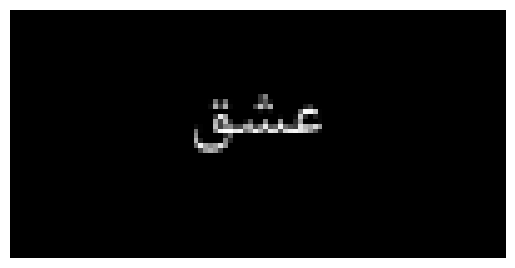

In [20]:
plt.imshow(cv2.cvtColor(X_train[5], cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

In [22]:
padded_sequences[5]

array([98,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0], dtype=int32)